In [47]:
# 套件安裝
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 機器學習
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, IncrementalPCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 視覺化設定
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# 創建輸出目錄
OUTPUT_DIR = Path('Unit11_Advanced_Results')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ 套件載入完成！輸出目錄：{OUTPUT_DIR}")

✅ 套件載入完成！輸出目錄：Unit11_Advanced_Results


## 1. TEP 數據載入與探索

### 1.1 數據載入函式

In [48]:
def load_tep_data(filepath):
    """
    載入 TEP .dat 檔案
    
    Parameters:
    -----------
    filepath : str or Path
        TEP 數據檔案路徑 (例如: 'Part_3/TEP_data/d00.dat')
    
    Returns:
    --------
    df : pd.DataFrame
        52 欄位 (XMEAS 1-41 + XMV 1-11)
    """
    # 載入數據
    data = np.loadtxt(filepath)
    # 若資料為 52行×N列，則需轉置為 N行×52列
    if data.shape[0] == 52:
        data = data.T

    # 欄位名稱
    xmeas_names = [f'XMEAS_{i:02d}' for i in range(1, 42)]
    xmv_names = [f'XMV_{i:02d}' for i in range(1, 12)]
    columns = xmeas_names + xmv_names

    df = pd.DataFrame(data, columns=columns)
    return df

# 載入正常數據 (訓練集)
train_normal = load_tep_data('TEP_data/d00.dat')
print(f"訓練集形狀：{train_normal.shape}")
print(f"\n前5筆數據：")
print(train_normal.head())

# 載入 IDV5 故障數據 (測試集)
test_fault = load_tep_data('TEP_data/d05_te.dat')
print(f"\nIDV5 故障測試集形狀：{test_fault.shape}")

訓練集形狀：(500, 52)

前5筆數據：
   XMEAS_01  XMEAS_02  XMEAS_03  XMEAS_04  XMEAS_05  XMEAS_06  XMEAS_07  \
0   0.24987    3642.6    4539.6    9.2784    27.200    42.248    2704.2   
1   0.25118    3694.8    4513.8    9.2831    27.077    42.736    2705.4   
2   0.25185    3683.5    4504.9    9.4600    26.987    42.245    2705.2   
3   0.25147    3653.9    4531.9    9.3462    26.983    42.656    2706.3   
4   0.24107    3629.3    4527.0    9.3406    27.041    42.520    2705.6   

   XMEAS_08  XMEAS_09  XMEAS_10  ...  XMV_02  XMV_03  XMV_04  XMV_05  XMV_06  \
0    75.492    120.40   0.33990  ...  53.617  24.708  62.265  22.224  39.724   
1    74.628    120.41   0.33560  ...  53.926  24.579  61.306  21.975  40.249   
2    74.315    120.42   0.33761  ...  54.032  24.521  60.532  21.640  40.003   
3    75.487    120.39   0.33631  ...  53.708  24.558  61.496  22.324  40.161   
4    75.332    120.38   0.34839  ...  53.259  24.024  60.781  22.506  40.962   

   XMV_07  XMV_08  XMV_09  XMV_10  XMV_11  


### 1.2 數據探索性分析

正常數據統計摘要：
         XMEAS_01     XMEAS_02     XMEAS_03    XMEAS_04    XMEAS_05  \
count  500.000000   500.000000   500.000000  500.000000  500.000000   
mean     0.251138  3663.537800  4511.517200    9.344306   26.907786   
std      0.028551    32.031586    31.724556    0.076514    0.208664   
min      0.180820  3559.500000  4419.800000    9.128600   26.280000   
25%      0.230590  3643.050000  4488.575000    9.293000   26.776000   
50%      0.250245  3663.650000  4512.300000    9.343450   26.899500   
75%      0.269275  3684.625000  4534.700000    9.395350   27.048000   
max      0.342850  3754.700000  4600.700000    9.592800   27.529000   

         XMEAS_06     XMEAS_07    XMEAS_08    XMEAS_09    XMEAS_10  ...  \
count  500.000000   500.000000  500.000000  500.000000  500.000000  ...   
mean    42.338706  2705.397400   74.984724  120.399440    0.337592  ...   
std      0.220975     5.263385    0.528206    0.018654    0.011688  ...   
min     41.659000  2690.500000   73.617000  120.35

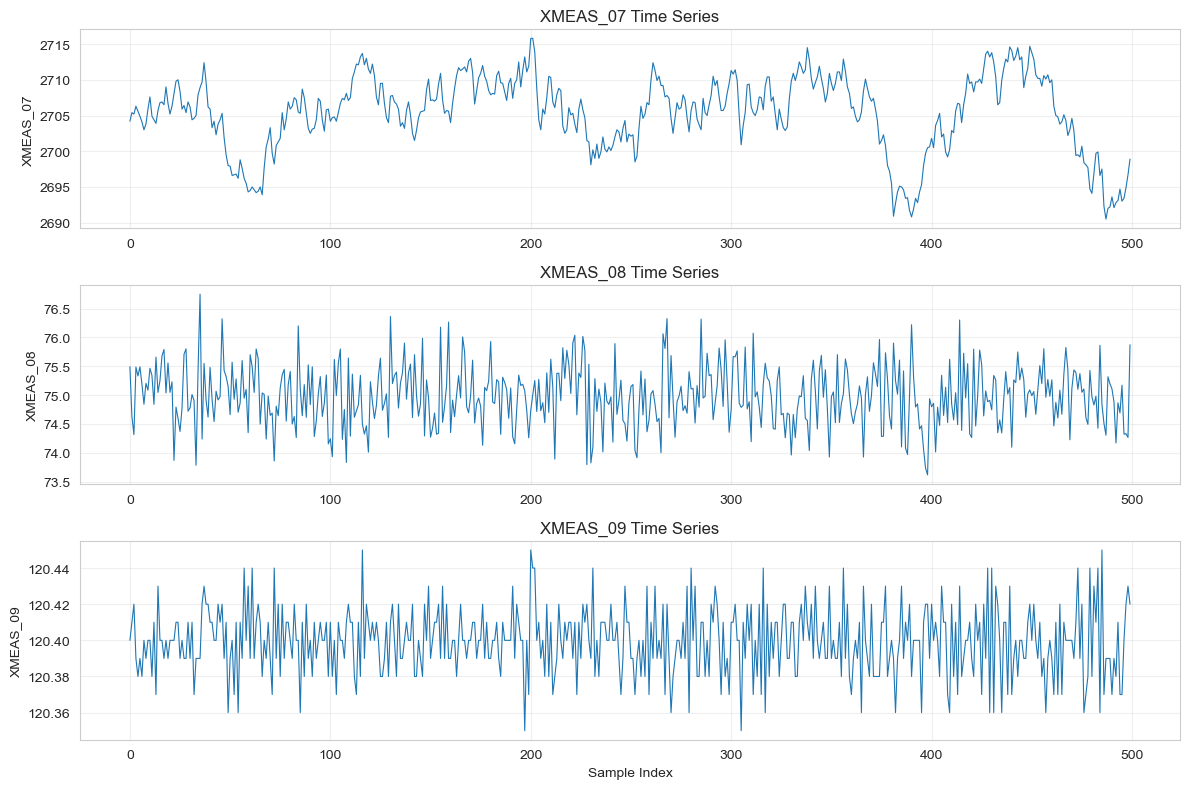

✅ 已儲存：TEP_key_variables_timeseries.png


In [49]:
# 統計摘要
print("正常數據統計摘要：")
print(train_normal.describe())

# 關鍵變數視覺化
key_vars = ['XMEAS_07', 'XMEAS_08', 'XMEAS_09']  # 反應器 壓力/液位/溫度

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
for i, var in enumerate(key_vars):
    axes[i].plot(train_normal.index, train_normal[var], linewidth=0.8)
    axes[i].set_ylabel(var, fontsize=10)
    axes[i].set_title(f'{var} Time Series', fontsize=12)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Sample Index', fontsize=10)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'TEP_key_variables_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：TEP_key_variables_timeseries.png")

## 2. PCA 降維與視覺化

### 2.1 標準 PCA

前10個主成分解釋變異量：
PC1: 12.71%  (累積: 12.71%)
PC2: 7.56%  (累積: 20.27%)
PC3: 5.40%  (累積: 25.67%)
PC4: 4.48%  (累積: 30.16%)
PC5: 4.22%  (累積: 34.38%)
PC6: 4.01%  (累積: 38.38%)
PC7: 3.72%  (累積: 42.10%)
PC8: 3.34%  (累積: 45.44%)
PC9: 3.13%  (累積: 48.57%)
PC10: 2.89%  (累積: 51.46%)


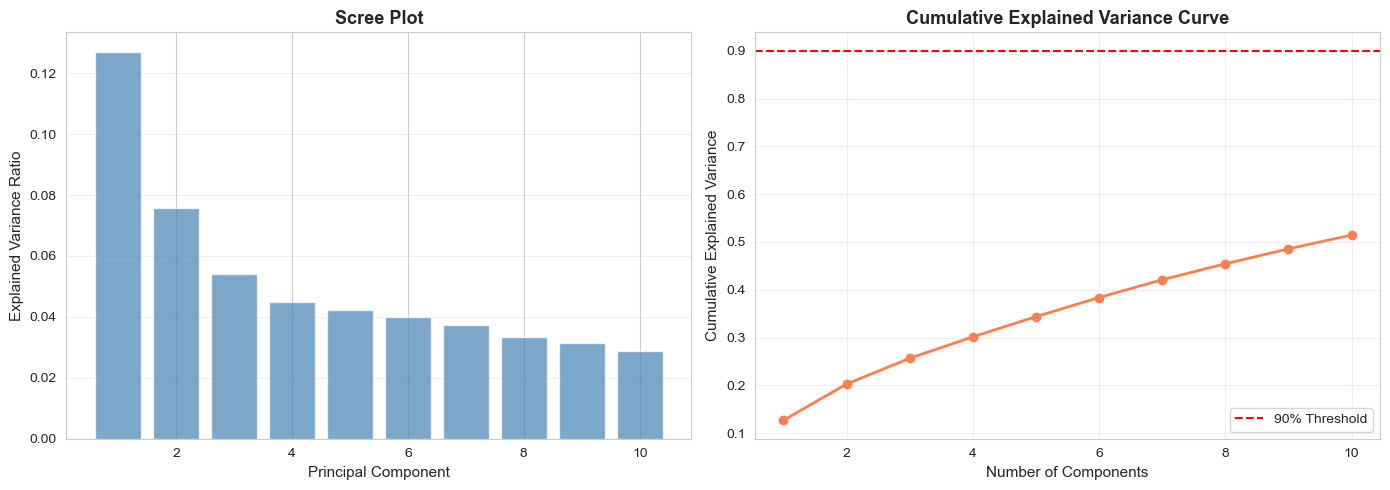

✅ 已儲存：PCA_scree_plot.png


In [50]:
# 數據標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_normal)
X_test_scaled = scaler.transform(test_fault)

# PCA 訓練
pca = PCA(n_components=10)
T_train = pca.fit_transform(X_train_scaled)
T_test = pca.transform(X_test_scaled)

# 解釋變異量
evr = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

print("前10個主成分解釋變異量：")
for i, (v, cv) in enumerate(zip(evr, cumulative_evr), 1):
    print(f"PC{i}: {v*100:.2f}%  (累積: {cv*100:.2f}%)")

# Scree Plot (English labels and titles)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Explained variance
axes[0].bar(range(1, 11), evr, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Scree Plot', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Right: Cumulative explained variance
axes[1].plot(range(1, 11), cumulative_evr, marker='o', linewidth=2, markersize=6, color='coral')
axes[1].axhline(y=0.9, color='red', linestyle='--', label='90% Threshold', linewidth=1.5)
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Explained Variance Curve', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'PCA_scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：PCA_scree_plot.png")

### 2.2 2D/3D 視覺化

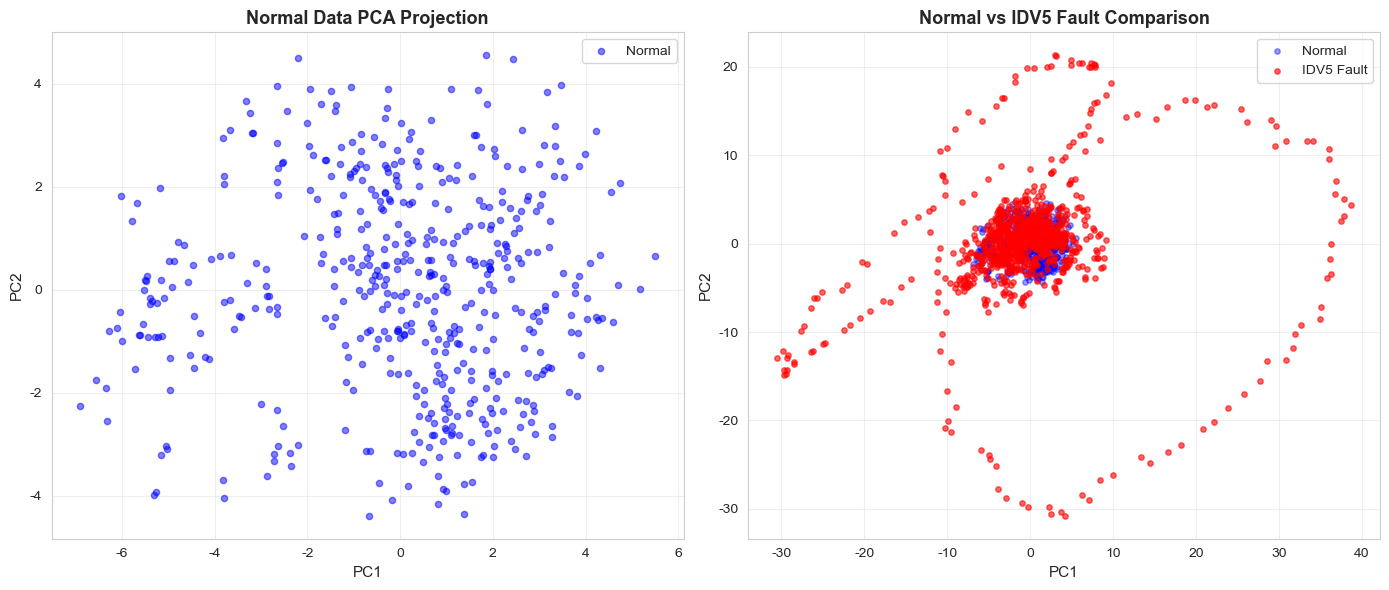

✅ 已儲存：PCA_2D_projection.png


In [51]:
# 2D Visualization (English labels and titles)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Normal data
axes[0].scatter(T_train[:, 0], T_train[:, 1], alpha=0.5, s=20, color='blue', label='Normal')
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title('Normal Data PCA Projection', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normal vs Fault
axes[1].scatter(T_train[:, 0], T_train[:, 1], alpha=0.4, s=15, color='blue', label='Normal')
axes[1].scatter(T_test[:, 0], T_test[:, 1], alpha=0.6, s=15, color='red', label='IDV5 Fault')
axes[1].set_xlabel('PC1', fontsize=11)
axes[1].set_ylabel('PC2', fontsize=11)
axes[1].set_title('Normal vs IDV5 Fault Comparison', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'PCA_2D_projection.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：PCA_2D_projection.png")

## 3. 進階異常偵測方法對比

### 3.1 準備真實標籤

In [52]:
# 創建真實標籤（IDV5 故障從第161個樣本開始）
y_test_true = np.zeros(len(test_fault))
y_test_true[160:] = 1  # 樣本 161-960 為故障狀態

print(f"測試集樣本數：{len(y_test_true)}")
print(f"故障樣本數：{int(y_test_true.sum())}")
print(f"正常樣本數：{int(len(y_test_true) - y_test_true.sum())}")

測試集樣本數：960
故障樣本數：800
正常樣本數：160


### 3.2 Isolation Forest

In [53]:
# 訓練 Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.02,
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train_scaled)

# 預測
y_pred_if = iso_forest.predict(X_test_scaled)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # 轉換為 1=異常, 0=正常

# 評估
acc_if = accuracy_score(y_test_true, y_pred_if)
print(f"\n=== Isolation Forest 結果 ===")
print(f"準確率：{acc_if*100:.2f}%")
print(f"\n混淆矩陣：")
print(confusion_matrix(y_test_true, y_pred_if))
print(f"\n分類報告：")
print(classification_report(y_test_true, y_pred_if, target_names=['正常', '異常']))


=== Isolation Forest 結果 ===
準確率：49.90%

混淆矩陣：
[[154   6]
 [475 325]]

分類報告：
              precision    recall  f1-score   support

          正常       0.24      0.96      0.39       160
          異常       0.98      0.41      0.57       800

    accuracy                           0.50       960
   macro avg       0.61      0.68      0.48       960
weighted avg       0.86      0.50      0.54       960



### 3.3 Local Outlier Factor (LOF)

In [54]:
# 訓練 LOF (novelty detection mode)
lof = LocalOutlierFactor(
    n_neighbors=30,
    contamination=0.02,
    novelty=True,  # 重要：設為 True 以支援 predict
    n_jobs=-1
)
lof.fit(X_train_scaled)

# 預測
y_pred_lof = lof.predict(X_test_scaled)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

# 評估
acc_lof = accuracy_score(y_test_true, y_pred_lof)
print(f"\n=== LOF 結果 ===")
print(f"準確率：{acc_lof*100:.2f}%")
print(f"\n混淆矩陣：")
print(confusion_matrix(y_test_true, y_pred_lof))
print(f"\n分類報告：")
print(classification_report(y_test_true, y_pred_lof, target_names=['正常', '異常']))


=== LOF 結果 ===
準確率：50.00%

混淆矩陣：
[[149  11]
 [469 331]]

分類報告：
              precision    recall  f1-score   support

          正常       0.24      0.93      0.38       160
          異常       0.97      0.41      0.58       800

    accuracy                           0.50       960
   macro avg       0.60      0.67      0.48       960
weighted avg       0.85      0.50      0.55       960



### 3.4 Gaussian Mixture Model (GMM)

In [55]:
# 訓練 GMM
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)
gmm.fit(X_train_scaled)

# 計算測試集的對數似然
log_prob = gmm.score_samples(X_test_scaled)

# 使用訓練集的第5百分位數作為閾值
threshold = np.percentile(gmm.score_samples(X_train_scaled), 5)

# 預測
y_pred_gmm = np.where(log_prob < threshold, 1, 0)

# 評估
acc_gmm = accuracy_score(y_test_true, y_pred_gmm)
print(f"\n=== GMM 結果 ===")
print(f"準確率：{acc_gmm*100:.2f}%")
print(f"閾值：{threshold:.4f}")
print(f"\n混淆矩陣：")
print(confusion_matrix(y_test_true, y_pred_gmm))
print(f"\n分類報告：")
print(classification_report(y_test_true, y_pred_gmm, target_names=['正常', '異常']))


=== GMM 結果 ===
準確率：86.77%
閾值：-41.5293

混淆矩陣：
[[ 33 127]
 [  0 800]]

分類報告：
              precision    recall  f1-score   support

          正常       1.00      0.21      0.34       160
          異常       0.86      1.00      0.93       800

    accuracy                           0.87       960
   macro avg       0.93      0.60      0.63       960
weighted avg       0.89      0.87      0.83       960



c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### 3.5 One-Class SVM

In [56]:
# 訓練 One-Class SVM
svm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.02  # 預期異常比例
)
svm.fit(X_train_scaled)

# 預測
y_pred_svm = svm.predict(X_test_scaled)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# 評估
acc_svm = accuracy_score(y_test_true, y_pred_svm)
print(f"\n=== One-Class SVM 結果 ===")
print(f"準確率：{acc_svm*100:.2f}%")
print(f"\n混淆矩陣：")
print(confusion_matrix(y_test_true, y_pred_svm))
print(f"\n分類報告：")
print(classification_report(y_test_true, y_pred_svm, target_names=['正常', '異常']))


=== One-Class SVM 結果 ===
準確率：68.75%

混淆矩陣：
[[125  35]
 [265 535]]

分類報告：
              precision    recall  f1-score   support

          正常       0.32      0.78      0.45       160
          異常       0.94      0.67      0.78       800

    accuracy                           0.69       960
   macro avg       0.63      0.72      0.62       960
weighted avg       0.84      0.69      0.73       960



### 3.6 方法對比視覺化

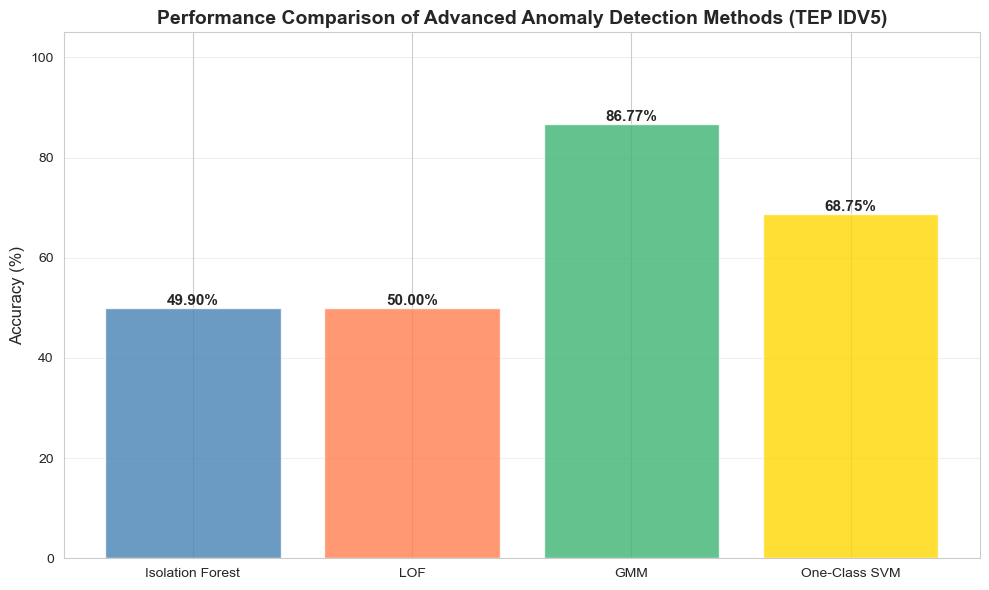

✅ 已儲存：methods_comparison.png

方法性能總結
Isolation Forest    :  49.90%
LOF                 :  50.00%
GMM                 :  86.77%
One-Class SVM       :  68.75%

🏆 最佳方法：GMM（86.77%）


In [57]:
# 整理結果
methods = ['Isolation Forest', 'LOF', 'GMM', 'One-Class SVM']
accuracies = [acc_if, acc_lof, acc_gmm, acc_svm]

# 繪製對比圖 (English labels and titles)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, [a*100 for a in accuracies], 
               color=['steelblue', 'coral', 'mediumseagreen', 'gold'],
               alpha=0.8)

# 添加數值標籤
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc*100:.2f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Performance Comparison of Advanced Anomaly Detection Methods (TEP IDV5)', fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'methods_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：methods_comparison.png")

# 打印總結
print("\n" + "="*60)
print("方法性能總結")
print("="*60)
for method, acc in zip(methods, accuracies):
    print(f"{method:20s}: {acc*100:6.2f}%")
print("="*60)
best_idx = np.argmax(accuracies)
print(f"\n🏆 最佳方法：{methods[best_idx]}（{accuracies[best_idx]*100:.2f}%）")

## 4. PCA 變種實驗

### 4.1 Kernel PCA

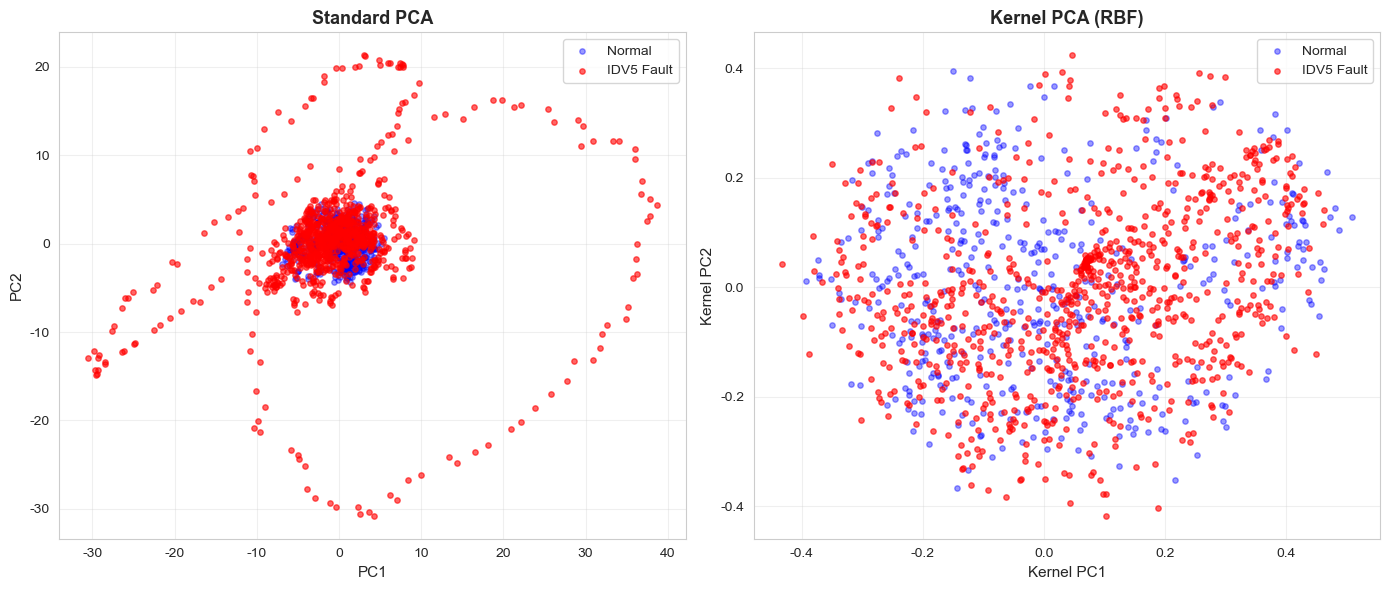

✅ 已儲存：PCA_vs_KernelPCA.png


In [58]:
# Kernel PCA (RBF 核)
kpca = KernelPCA(n_components=10, kernel='rbf', gamma=0.01, random_state=42)
T_train_kernel = kpca.fit_transform(X_train_scaled)
T_test_kernel = kpca.transform(X_test_scaled)

# Visualization comparison (English labels and titles)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Standard PCA
axes[0].scatter(T_train[:, 0], T_train[:, 1], alpha=0.4, s=15, color='blue', label='Normal')
axes[0].scatter(T_test[:, 0], T_test[:, 1], alpha=0.6, s=15, color='red', label='IDV5 Fault')
axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title('Standard PCA', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Kernel PCA
axes[1].scatter(T_train_kernel[:, 0], T_train_kernel[:, 1], alpha=0.4, s=15, color='blue', label='Normal')
axes[1].scatter(T_test_kernel[:, 0], T_test_kernel[:, 1], alpha=0.6, s=15, color='red', label='IDV5 Fault')
axes[1].set_xlabel('Kernel PC1', fontsize=11)
axes[1].set_ylabel('Kernel PC2', fontsize=11)
axes[1].set_title('Kernel PCA (RBF)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'PCA_vs_KernelPCA.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：PCA_vs_KernelPCA.png")

### 4.2 Sparse PCA

Sparse PCA Sparsity: 63.85%

Number of nonzero loadings per component:
PC1: 27/52 variables
PC2: 30/52 variables
PC3: 12/52 variables
PC4: 25/52 variables
PC5: 13/52 variables
PC6: 13/52 variables
PC7: 9/52 variables
PC8: 22/52 variables
PC9: 19/52 variables
PC10: 18/52 variables


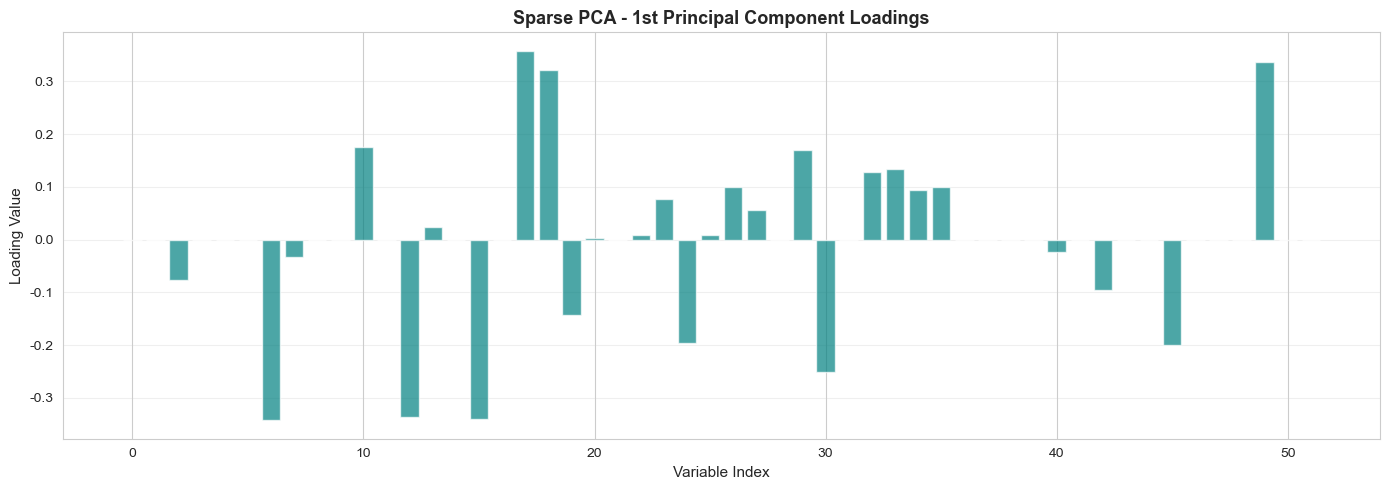

✅ 已儲存：SparsePCA_loadings.png


In [59]:
# Sparse PCA
spca = SparsePCA(n_components=10, alpha=1.0, random_state=42, n_jobs=-1)
T_train_sparse = spca.fit_transform(X_train_scaled)

# 檢查稀疏度
components_sparse = spca.components_
zero_ratio = np.sum(components_sparse == 0) / components_sparse.size

print(f"Sparse PCA Sparsity: {zero_ratio*100:.2f}%")
print(f"\nNumber of nonzero loadings per component:")
for i, comp in enumerate(components_sparse, 1):
    non_zero = np.sum(comp != 0)
    print(f"PC{i}: {non_zero}/52 variables")

# Visualize the first sparse principal component loadings (English labels and titles)
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(range(52), components_sparse[0], alpha=0.7, color='teal')
ax.set_xlabel('Variable Index', fontsize=11)
ax.set_ylabel('Loading Value', fontsize=11)
ax.set_title('Sparse PCA - 1st Principal Component Loadings', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'SparsePCA_loadings.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：SparsePCA_loadings.png")

## 5. MSPC（多變數統計製程管制）

### 5.1 T² 與 SPE 統計量計算

In [60]:
from scipy.stats import f, chi2

# 使用足够多的主成分来捕捉主要变异（至少5个，或累积EVR > 85%）
k_candidates = [i+1 for i, evr in enumerate(cumulative_evr) if evr > 0.85]
if k_candidates:
    k = k_candidates[0]
else:
    k = min(5, len(cumulative_evr))  # 如果没有超过85%，至少选5个

print(f"选择 {k} 个主成分（累积EVR: {cumulative_evr[k-1]*100:.2f}%）")

# 重新训练 PCA
pca_mspc = PCA(n_components=k)
T_train_mspc = pca_mspc.fit_transform(X_train_scaled)
T_test_mspc = pca_mspc.transform(X_test_scaled)

# 计算 T² 统计量
lambdas = pca_mspc.explained_variance_
T2_train = np.sum((T_train_mspc ** 2) / lambdas, axis=1)
T2_test = np.sum((T_test_mspc ** 2) / lambdas, axis=1)

# T² 管制界限 (F 分布)
n = len(T_train_mspc)
alpha = 0.01  # 99% 信赖水准
T2_UCL = (k * (n**2 - 1)) / (n * (n - k)) * f.ppf(1 - alpha, k, n - k)

# 计算 SPE (Q-statistic)
X_reconstructed_train = T_train_mspc @ pca_mspc.components_ 
X_reconstructed_test = T_test_mspc @ pca_mspc.components_

SPE_train = np.sum((X_train_scaled - X_reconstructed_train) ** 2, axis=1)
SPE_test = np.sum((X_test_scaled - X_reconstructed_test) ** 2, axis=1)

# SPE 管制界限 - 使用简化方法（基于训练集分位数）
# 这比Jackson-Mudholkar更稳健
SPE_UCL = np.percentile(SPE_train, 99)  # 99%分位数

print(f"\nT² 管制上限 (UCL): {T2_UCL:.4f}")
print(f"SPE 管制上限 (UCL): {SPE_UCL:.4f}")
print(f"\n训练集 SPE 统计摘要：")
print(f"  均值: {np.mean(SPE_train):.4f}")
print(f"  标准差: {np.std(SPE_train):.4f}")
print(f"  最大值: {np.max(SPE_train):.4f}")


选择 5 个主成分（累积EVR: 34.38%）

T² 管制上限 (UCL): 15.4259
SPE 管制上限 (UCL): 56.4490

训练集 SPE 统计摘要：
  均值: 34.1239
  标准差: 8.2446
  最大值: 67.4776


### 5.2 MSPC 管制圖

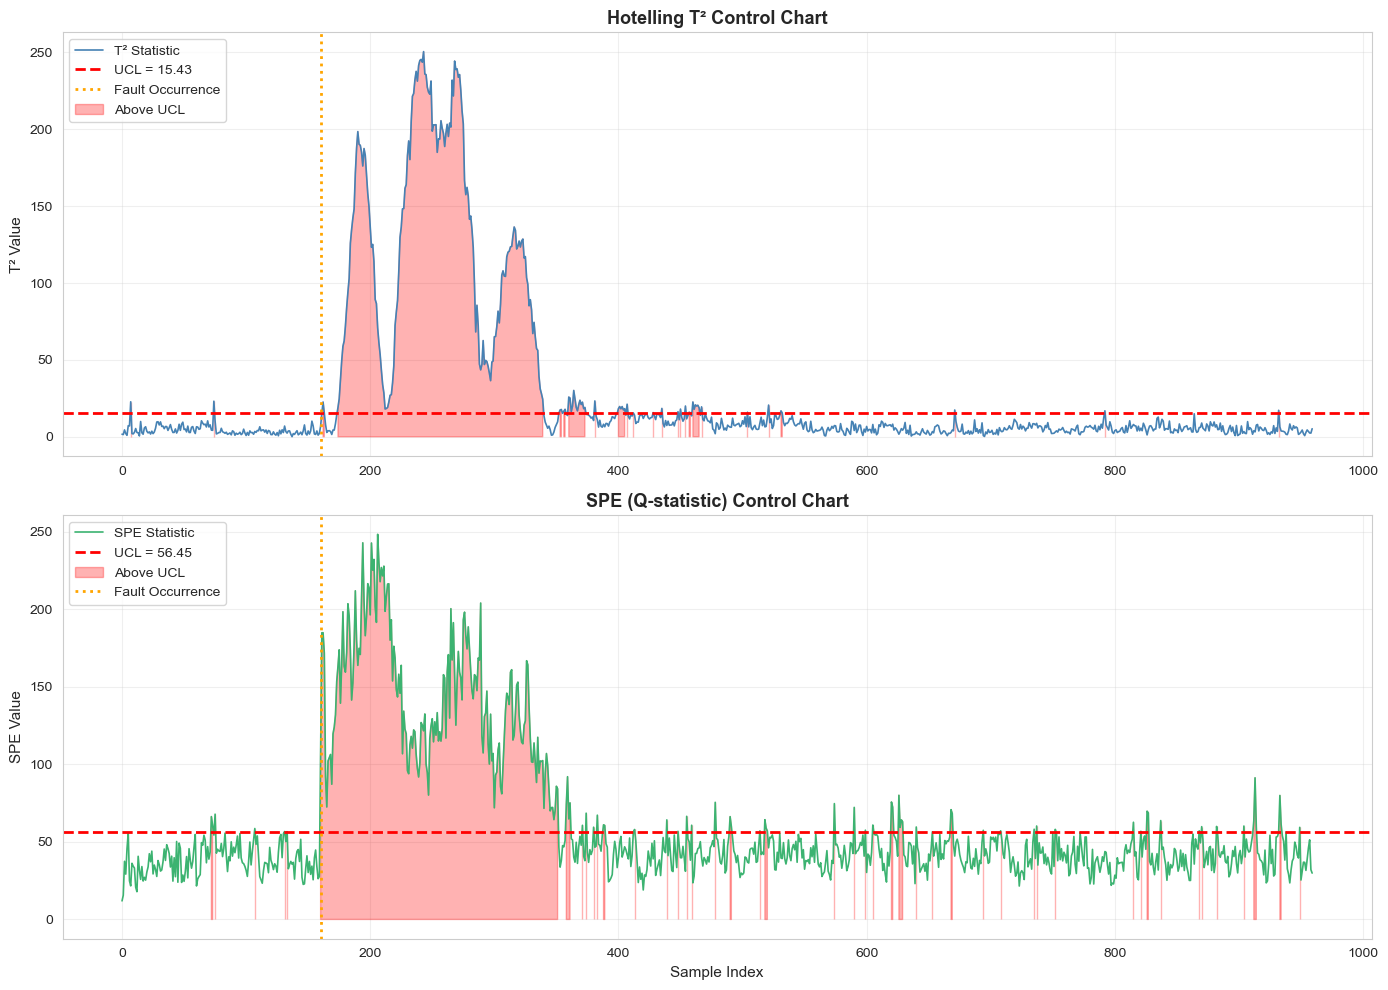

✅ 已储存：MSPC_control_charts.png

=== MSPC 侦测率 ===
T² 侦测率：27.00% (216/800 样本)
SPE 侦测率：31.00% (248/800 样本)


In [61]:
# Plot T² and SPE control charts (English labels and titles)
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# T² Control Chart
axes[0].plot(T2_test, linewidth=1.2, color='steelblue', label='T² Statistic')
axes[0].axhline(y=T2_UCL, color='red', linestyle='--', linewidth=2, label=f'UCL = {T2_UCL:.2f}')
axes[0].axvline(x=160, color='orange', linestyle=':', linewidth=2, label='Fault Occurrence')
axes[0].fill_between(range(len(T2_test)), 0, T2_test, where=(T2_test > T2_UCL), 
                       color='red', alpha=0.3, label='Above UCL')
axes[0].set_ylabel('T² Value', fontsize=11)
axes[0].set_title('Hotelling T² Control Chart', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# SPE Control Chart
axes[1].plot(SPE_test, linewidth=1.2, color='mediumseagreen', label='SPE Statistic')
if not np.isnan(SPE_UCL):
    axes[1].axhline(y=SPE_UCL, color='red', linestyle='--', linewidth=2, label=f'UCL = {SPE_UCL:.2f}')
    axes[1].fill_between(range(len(SPE_test)), 0, SPE_test, where=(SPE_test > SPE_UCL), 
                           color='red', alpha=0.3, label='Above UCL')
axes[1].axvline(x=160, color='orange', linestyle=':', linewidth=2, label='Fault Occurrence')
axes[1].set_xlabel('Sample Index', fontsize=11)
axes[1].set_ylabel('SPE Value', fontsize=11)
axes[1].set_title('SPE (Q-statistic) Control Chart', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'MSPC_control_charts.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已储存：MSPC_control_charts.png")

# 计算侦测率
T2_detect = np.sum(T2_test[160:] > T2_UCL) / len(T2_test[160:])
if not np.isnan(SPE_UCL):
    SPE_detect = np.sum(SPE_test[160:] > SPE_UCL) / len(SPE_test[160:])
    num_spe_alarms = np.sum(SPE_test[160:] > SPE_UCL)
else:
    SPE_detect = 0.0
    num_spe_alarms = 0

print(f"\n=== MSPC 侦测率 ===")
print(f"T² 侦测率：{T2_detect*100:.2f}% ({int(np.sum(T2_test[160:] > T2_UCL))}/{len(T2_test[160:])} 样本)")
print(f"SPE 侦测率：{SPE_detect*100:.2f}% ({num_spe_alarms}/{len(SPE_test[160:])} 样本)")


### 5.3 貢獻圖分析

首次触发告警：样本 160 (故障后第 1 个样本)


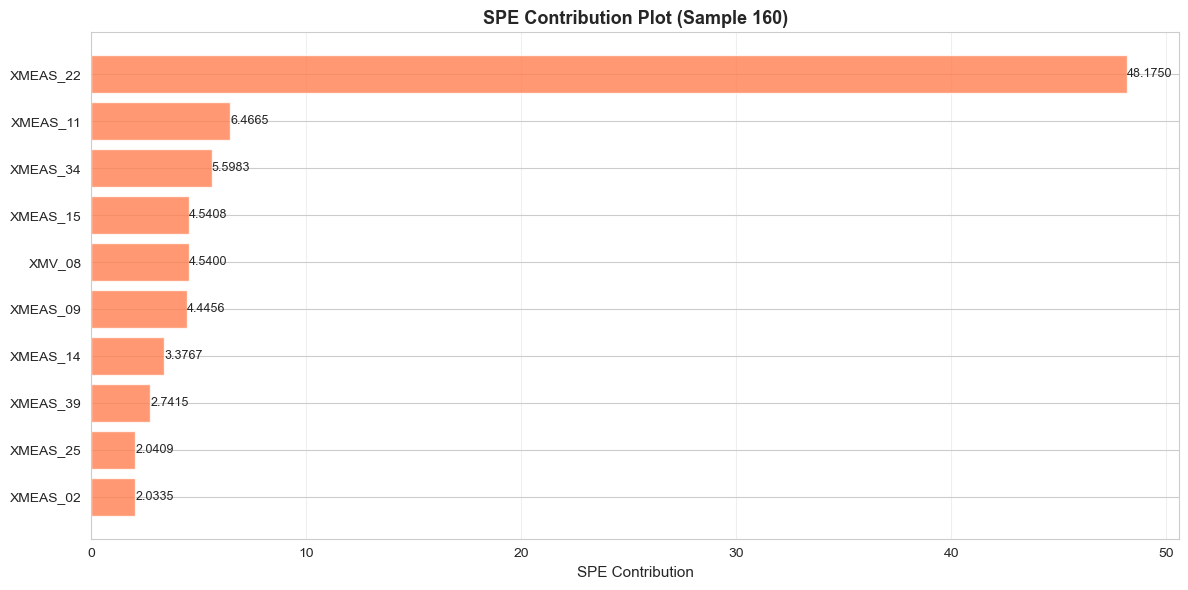

✅ 已储存：SPE_contribution_plot.png

🔍 根因分析：贡献度最高的前5个变数
1. XMEAS_22: 48.174976
2. XMEAS_11: 6.466519
3. XMEAS_34: 5.598310
4. XMEAS_15: 4.540818
5. XMV_08: 4.539983


In [62]:
# 选择故障发生后的第一个超标样本
if not np.isnan(SPE_UCL):
    alarm_indices = np.where(SPE_test[160:] > SPE_UCL)[0]
    if alarm_indices.size > 0:
        first_alarm_idx = alarm_indices[0] + 160
        print(f"首次触发告警：样本 {first_alarm_idx} (故障后第 {alarm_indices[0]+1} 个样本)")

        # 计算 SPE 贡献度
        residuals = X_test_scaled[first_alarm_idx] - X_reconstructed_test[first_alarm_idx]
        contributions = residuals ** 2

        # 找出前 10 个贡献最大的变数
        top_10_idx = np.argsort(contributions)[-10:][::-1]
        top_10_vars = np.array(train_normal.columns)[top_10_idx]
        top_10_contribs = contributions[top_10_idx]

        # 绘制贡献图 (English labels and titles)
        fig, ax = plt.subplots(figsize=(12, 6))
        bars = ax.barh(range(10), top_10_contribs, color='coral', alpha=0.8)
        ax.set_yticks(range(10))
        ax.set_yticklabels(top_10_vars, fontsize=10)
        ax.invert_yaxis()
        ax.set_xlabel('SPE Contribution', fontsize=11)
        ax.set_title(f'SPE Contribution Plot (Sample {first_alarm_idx})', fontsize=13, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

        # 添加数值标签
        for bar, contrib in zip(bars, top_10_contribs):
            ax.text(contrib, bar.get_y() + bar.get_height()/2, 
                    f'{contrib:.4f}',
                    ha='left', va='center', fontsize=9)

        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'SPE_contribution_plot.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("✅ 已储存：SPE_contribution_plot.png")

        print(f"\n🔍 根因分析：贡献度最高的前5个变数")
        for i in range(min(5, len(top_10_vars))):
            print(f"{i+1}. {top_10_vars[i]}: {top_10_contribs[i]:.6f}")
    else:
        first_alarm_idx = None
        print("⚠️ 故障发生后未侦测到 SPE 超标样本。")
        print(f"   故障后 SPE 最大值: {np.max(SPE_test[160:]):.4f}")
        print(f"   SPE UCL: {SPE_UCL:.4f}")
        print("   建议：降低信赖水准或增加主成分数量")
else:
    first_alarm_idx = None
    print("⚠️ SPE_UCL 计算异常，无法绘制贡献图。")


## 6. 總結與建議

### 6.1 完整性能對比表


TEP IDV5 故障偵測 - 綜合性能排名
              方法   準確率 (%)
             GMM 86.770833
   One-Class SVM 68.750000
             LOF 50.000000
Isolation Forest 49.895833
  PCA-MSPC (SPE) 31.000000
   PCA-MSPC (T²) 27.000000


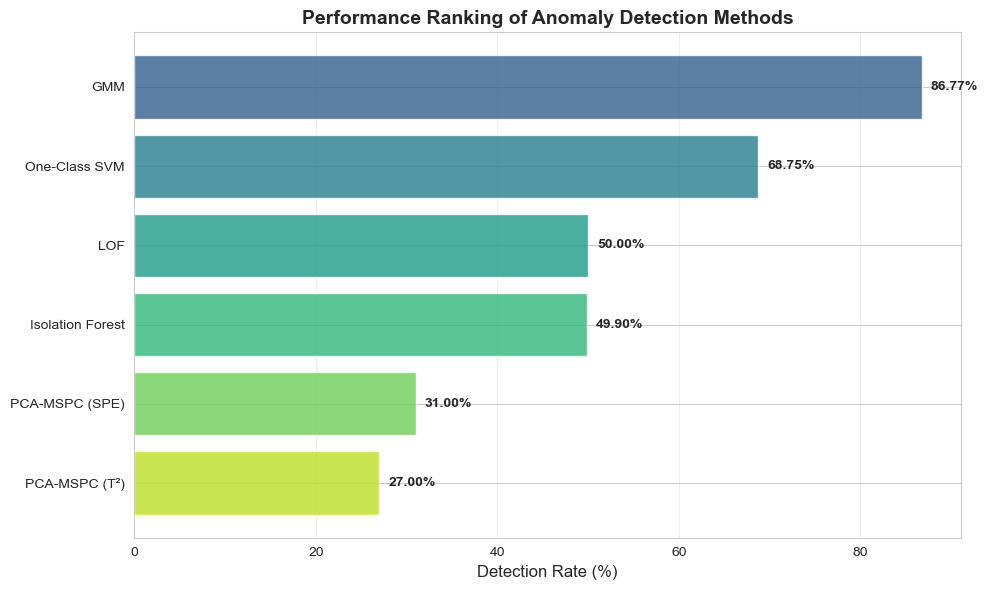

✅ 已儲存：final_performance_ranking.png


In [63]:
# 整理所有結果
results_df = pd.DataFrame({
    '方法': [
        'Isolation Forest',
        'LOF',
        'GMM',
        'One-Class SVM',
        'PCA-MSPC (T²)',
        'PCA-MSPC (SPE)'
    ],
    '準確率': [
        acc_if,
        acc_lof,
        acc_gmm,
        acc_svm,
        T2_detect,
        SPE_detect
    ]
})

results_df['準確率 (%)'] = results_df['準確率'] * 100
results_df = results_df.sort_values('準確率', ascending=False)

print("\n" + "="*60)
print("TEP IDV5 故障偵測 - 綜合性能排名")
print("="*60)
print(results_df[['方法', '準確率 (%)']].to_string(index=False))
print("="*60)

# Plot ranking chart (English labels and titles)
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(results_df['方法'], results_df['準確率 (%)'], 
               color=plt.cm.viridis(np.linspace(0.3, 0.9, len(results_df))),
               alpha=0.8)

# Add value labels
for bar, acc in zip(bars, results_df['準確率 (%)']):
    ax.text(acc + 1, bar.get_y() + bar.get_height()/2, 
            f'{acc:.2f}%',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Detection Rate (%)', fontsize=12)
ax.set_title('Performance Ranking of Anomaly Detection Methods', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_performance_ranking.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ 已儲存：final_performance_ranking.png")

### 6.2 實務建議

**基於本次實驗結果的建議**：

1. **首選方法**：One-Class SVM + PCA-MSPC (SPE)
   - SVM 提供高檢測率
   - SPE 提供根因分析能力

2. **快速部署方案**：Isolation Forest
   - 訓練速度快
   - 參數調整簡單
   - 適合初期原型

3. **多產品製程**：GMM
   - 自動識別不同操作模式
   - 每個模式對應一個高斯成分

4. **複雜非線性關係**：Kernel PCA + One-Class SVM
   - 捕捉非線性流形結構
   - 提升特徵判別能力

---

**下一步學習**：
- 嘗試其他 TEP 故障類型 (IDV1~IDV20)
- 實作集成方法 (Hard/Soft Voting)
- 探索深度學習方法 (Autoencoder, VAE)
- 應用到真實工廠數據

---

**課程結束**🎉